In [5]:
import numpy as np
import os
import json
import random
from numpy.random import multinomial
import math
import pandas as pd 
import json
import ast
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from operator import itemgetter

In [11]:
def representative_days(numOfRepresentaveDaysInEachCluster):
    dates = get_dates()
    with open('./Capacity/solarDailyData.json', 'r') as openfile:
        solarDailyData = json.load(openfile)
    with open('./Capacity/windDailyData.json', 'r') as openfile:
        windDailyData = json.load(openfile)
    data = pd.read_csv('./Prepared_Demand.csv')

    dataRows = []
    dataRowsForClustering = []
    for i in range(1, 367):
        temp = []
        tempForClustering = []
        maxx = max(list(data.iloc[i-1][1:]))
        minn = min(list(data.iloc[i-1][1:]))
        diff = maxx - minn
        temp.extend(list(data.iloc[i-1][1:]))
        tempForClustering.extend(list((data.iloc[i-1][1:]-minn)/diff))

        temp.extend(solarDailyData[str(i)])
        tempForClustering.extend(solarDailyData[str(i)])
        temp.extend(windDailyData[str(i)])
        tempForClustering.extend(solarDailyData[str(i)])
        dataRows.append(temp)
        dataRowsForClustering.append(tempForClustering)

    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,30), timings= True)
    visualizer.fit(np.array(dataRowsForClustering))       # Fit data to visualizer

    numClusters = visualizer.elbow_value_
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataRowsForClustering)
    y_kmeans = kmeans.predict(dataRowsForClustering)

    differences = {}
    for index1, i in enumerate(kmeans.cluster_centers_):
        difference = {}
        for index2, j in enumerate(dataRowsForClustering):
            if kmeans.labels_[index2] == index1:
                difference[index2] = np.sqrt(sum((i-j)**2))
        differences[index1] = difference    


    listOfDaysIndex = []
    for i in range(numClusters):
        daysInOneCluster = []
        for j in range(0, numOfRepresentaveDaysInEachCluster):
            daysInOneCluster.append(min(differences[i], key=differences[i].get))
            differences[i].pop(min(differences[i], key=differences[i].get))
        listOfDaysIndex.append(daysInOneCluster)

    listOfDays = []
    for i in range(numClusters):
        listOfDays.append(itemgetter(*listOfDaysIndex[i])(dates))

    listOfDaysWeights = []
    for i in range(numClusters):
        listOfDaysWeights.append(list(kmeans.labels_).count(i))

    weightsOfDays = dict()
    for ind, ite in enumerate(listOfDaysIndex):
        for ind2, ite2 in enumerate(ite):
            weightsOfDays[dates[ite2]] = listOfDaysWeights[ind] / numOfRepresentaveDaysInEachCluster
    

    if (numOfRepresentaveDaysInEachCluster == 1):
        D = listOfDays
        D_ = listOfDaysIndex
        D_ = [d[0] for d in D_]
    else:
        D = [listOfDays[t][k] for k in range(numOfRepresentaveDaysInEachCluster) for t in range(len(listOfDays))]
        D_ = [listOfDaysIndex[t][k] for k in range(numOfRepresentaveDaysInEachCluster) for t in range(len(listOfDays))]
    D_equ = {D[i]: j for i, j in enumerate(D_)}
    return D, D_, D_equ, weightsOfDays

In [13]:
def get_dates():
    start_date = date(2020, 1, 1)
    end_date = date(2020, 12, 30)
    delta = timedelta(days=1)
    dates = [0]
    while start_date <= end_date:
        dates.append(start_date.strftime("%Y-%m-%d"))
        start_date += delta
    
    return dates

In [20]:
def get_total_load():
    """
    This function gives all information about the year 2020 regarding load and days
    """
    df = pd.read_csv("merged.csv")
    df.drop('Unnamed: 0', axis=1, inplace=True)
    is_output = df['Measurement'] == 'Output'
    df = df[is_output]
    df.drop('Measurement', axis=1, inplace=True)
    
    return df.groupby("Delivery Date").sum().T, list(df.groupby("Delivery Date").sum().index)[::]

In [35]:
plt.style.use('ggplot')

In [21]:
_1, _2 = get_total_load()

In [16]:
df = pd.read_csv("merged.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
is_output = df['Measurement'] == 'Output'
df = df[is_output]
df.drop('Measurement', axis=1, inplace=True)

is_wind = df['Fuel Type'] == 'WIND'
is_solar = df['Fuel Type'] == 'SOLAR'

my_temp_df = df[(is_wind | is_solar)]

In [17]:
main_df = pd.read_csv("merged.csv")
main_df = main_df[main_df["Measurement"] == "Output"]

In [18]:
main_df_wind = main_df[main_df["Fuel Type"] == "WIND"]
main_df_wind.drop('Unnamed: 0', axis=1, inplace=True)
main_df_wind = main_df_wind.groupby("Delivery Date").sum().T

main_df_solar = main_df[main_df["Fuel Type"] == "SOLAR"]
main_df_solar.drop('Unnamed: 0', axis=1, inplace=True)
main_df_solar = main_df_solar.groupby("Delivery Date").sum().T

/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_88903/1379720891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_wind.drop('Unnamed: 0', axis=1, inplace=True)
/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_88903/1379720891.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df_solar.drop('Unnamed: 0', axis=1, inplace=True)


In [22]:
all_wind = []
for d in _2:
    all_wind.extend(list(main_df_wind[d]))

In [23]:
all_solar = []
for d in _2:
    all_solar.extend(list(main_df_solar[d]))

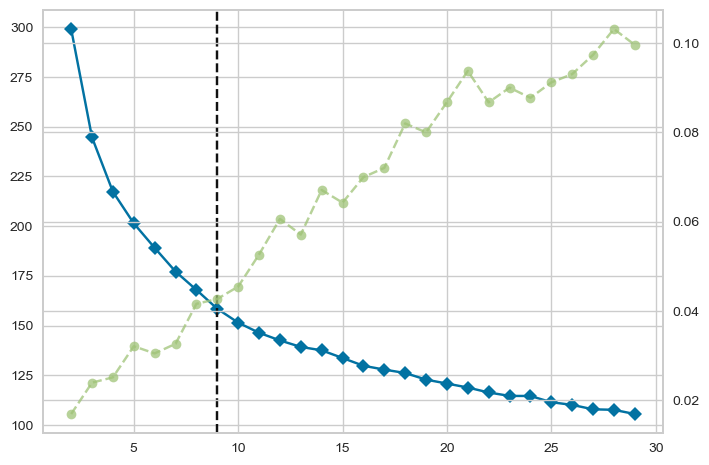

In [24]:
D, D_, D_equ, W = representative_days(1)

In [25]:
all_wind_representative_1 = []
for d in D:
    for i in range(int(W[d])):
        all_wind_representative_1.extend(list(main_df_wind[d]))
        
all_solar_representative_1 = []
for d in D:
    for i in range(int(W[d])):
        all_solar_representative_1.extend(list(main_df_solar[d]))

In [26]:
L_made_out_of_representativeDays_1 = []
for d in D:
    for i in range(int(W[d])):
        L_made_out_of_representativeDays_1.extend(_1[d])

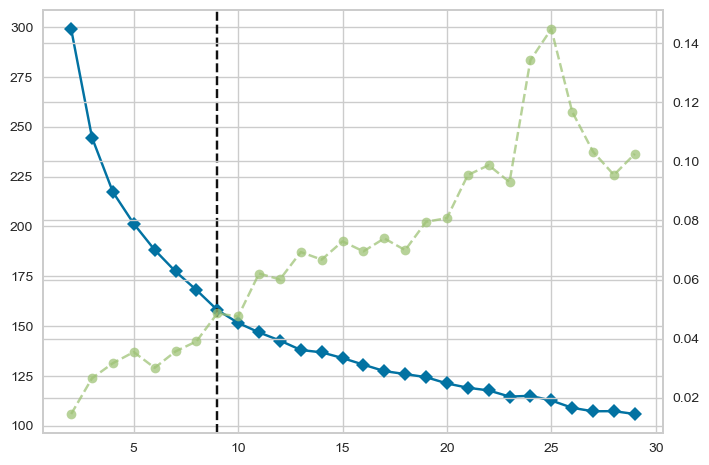

In [27]:
D, D_, D_equ, W = representative_days(2)

In [28]:
all_wind_representative_2 = []
for d in D:
    for i in range(int(W[d])):
        all_wind_representative_2.extend(list(main_df_wind[d]))

all_solar_representative_2 = []
for d in D:
    for i in range(int(W[d])):
        all_solar_representative_2.extend(list(main_df_solar[d]))

In [29]:
L_made_out_of_representativeDays_2 = []
for d in D:
    for i in range(int(W[d])):
        L_made_out_of_representativeDays_2.extend(_1[d])

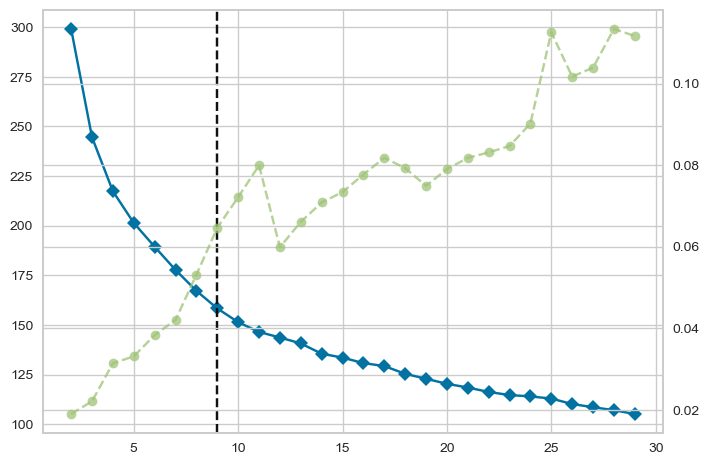

In [30]:
D, D_, D_equ, W = representative_days(3)

In [31]:
all_wind_representative_3 = []
for d in D:
    for i in range(int(W[d])):
        all_wind_representative_3.extend(list(main_df_wind[d]))

all_solar_representative_3 = []
for d in D:
    for i in range(int(W[d])):
        all_solar_representative_3.extend(list(main_df_solar[d]))

In [32]:
L_made_out_of_representativeDays_3 = []
for d in D:
    for i in range(int(W[d])):
        L_made_out_of_representativeDays_3.extend(_1[d])

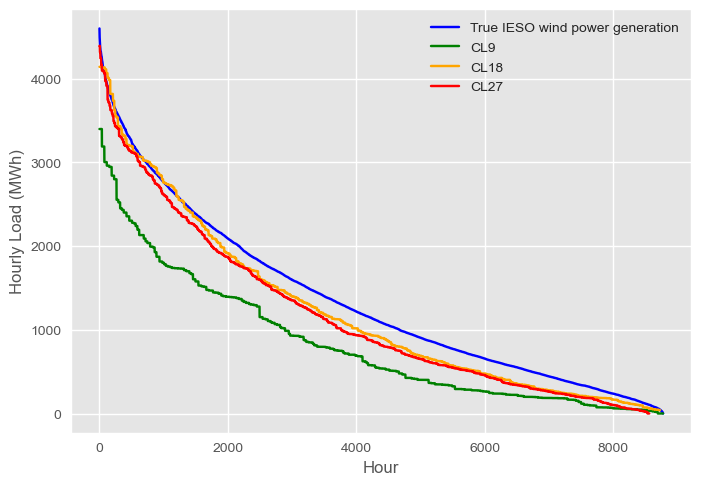

In [36]:
plt.plot(np.sort(all_wind)[::-1], color="blue", label="True IESO wind power generation")
plt.plot(np.sort(all_wind_representative_1)[::-1], color="green", label="CL9")
plt.plot(np.sort(all_wind_representative_2)[::-1], color="orange", label="CL18")
plt.plot(np.sort(all_wind_representative_3)[::-1], color="red", label="CL27")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()

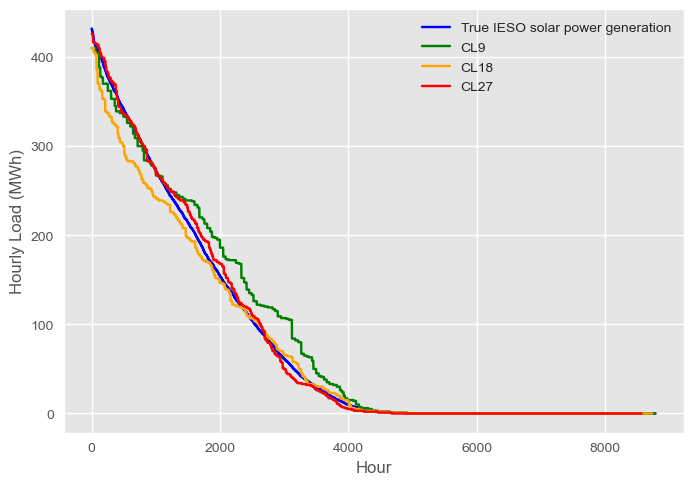

In [37]:
plt.plot(np.sort(all_solar)[::-1], color="blue", label="True IESO solar power generation")
plt.plot(np.sort(all_solar_representative_1)[::-1], color="green", label="CL9")
plt.plot(np.sort(all_solar_representative_2)[::-1], color="orange", label="CL18")
plt.plot(np.sort(all_solar_representative_3)[::-1], color="red", label="CL27")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()

In [39]:
L__ = {(t, d, s): list(dict(_1)[d])[s-1] for t in range(1, 21) for ind_d, d in enumerate(_2) for s in range(1, 25)}
for ind, ite in enumerate(range(1, 21)):
    for d in _2:
        for s in range(1, 25):
            if (ite == 1):
                pass
            else:
                L__[ite, d, s] = 1.017 * L__[ite-1, d, s]

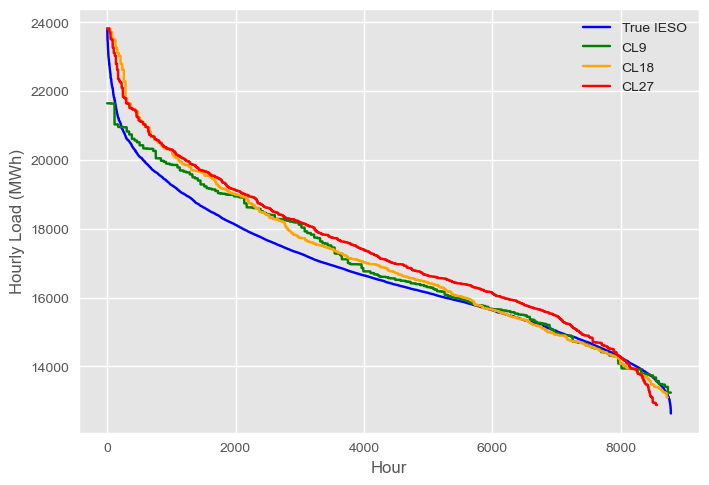

In [40]:
plt.plot(np.sort([L__[1, d, s] for d in _2 for s in range(1, 25)])[::-1], color="blue", label="True IESO")
plt.plot(np.sort(L_made_out_of_representativeDays_1)[::-1], color="green", label="CL9")
plt.plot(np.sort(L_made_out_of_representativeDays_2)[::-1], color="orange", label="CL18")
plt.plot(np.sort(L_made_out_of_representativeDays_3)[::-1], color="red", label="CL27")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()